# Fermionic bath code: Box initialization

In [1]:
using SpecialFunctions
using Plots
using QuadGK
using BenchmarkTools
using Roots

In [2]:
tₑ=1 #electron bandwidth= = σ
tB =2 #bath bandwidth
a1=2  #lattice constant
λ= 1 #system bath coupling
Tₑ=0# electron temperature
Temp_bath= 0.5 #the bath temperature
μ = 1  # chemical potential of the electron
μbath = 1 #chem potential of the bath

#time-simulation parameters
h= 0.05 #the time spacing
Time_max = 50 #the net time
N𝑡= Int(floor(Time_max/h)) #


#volume parameters
sitenum = 50 #gives the no. of sites in the lattice
a2=2*π*(1/(sitenum*a1)) #reciprocal space lattice constant
V_ph = collect(-0.5*sitenum*a2:a2:0.5*a2*(sitenum+1))

51-element Array{Float64,1}:
 -1.5707963267948968
 -1.5079644737231008
 -1.445132620651305
 -1.3823007675795091
 -1.3194689145077132
 -1.2566370614359175
 -1.1938052083641215
 -1.1309733552923258
 -1.0681415022205298
 -1.0053096491487339
 -0.9424777960769382
 -0.8796459430051422
 -0.8168140899333464
  ⋮
  0.8796459430051422
  0.9424777960769377
  1.0053096491487337
  1.0681415022205296
  1.1309733552923256
  1.1938052083641215
  1.2566370614359175
  1.319468914507713
  1.382300767579509
  1.4451326206513049
  1.5079644737231008
  1.5707963267948968

### Block for defining Green's functions and convolutions for the electrons

In [3]:
fermi = function (e,T,μ)
    return 1/(exp((e-μ)*(1/T))+1)
end

function ϵₑ(k)
    return tₑ*(1-cos(V_ph[k]*a1))           #(1-cos(V_ph[k]*a1))
end


function G₀ᴿ(k,t1,t2)
    if t1>=t2
        return -im*exp(-im*ϵₑ(k)*(t1-t2)*h)
    else
        return 0
    end
end

    #prints 0 for t1<t2

function G₀ᴷ(k,t1,t2,Telectron,μ)

    return -im*tanh((ϵₑ(k)-μ)/(2*Telectron))*exp(-im*ϵₑ(k)*(t1-t2)*h)
end


## Convolution function definition

function Fₑ(k,t₁,t₂)
    if t₁>t₂
        return sum(t->Σₑᴿ[t₁,t]*Gᴿmatrix[k][t,t₂]*h, collect(t₂:t₁))
    elseif t₁==t₂
        return 0
    else
        return "You're convoluting in the opposite direction. Possible error at RR/electron conv"
    end
end

function RKₑ(k,t1,t2) #∫₀ᵗ Σₑᴿ⋅Dᴷ
    if t1>1
        sum=0
        for i=1:t1-1
            sum = sum+Σₑᴿ[t1,i]*Gᴷmatrix[k][i,t2]*h
        end
        #result1 = sum(t->Σₑᴿ[t1,t]*Gᴷmatrix[k][t,t2]*h, collect(1:t1))
        return sum    
    else
        return 0
    end
end

function KAₑ(k,t1,t2) #∫₀⋅Dᴿ
    if t2>1
        sum=0
        for i=1:t2
            sum=sum+ Σₑᴷ[t1,i]* conj(Gᴿmatrix[k][t2,i]) * h
        end
        #result1 = sum( t->Σₑᴷ[t1,t]* conj(Gᴿmatrix[k][t2,t]) * h, collect(1:t2) )
        return sum
    else
        return 0
    end
end


KAₑ (generic function with 1 method)

In [4]:
function Σᴿ(t1,t2) 
    if t1>t2
        return -im*(λ^2)*(1/2)*(1/(tB))*(besselj1(2*tB*abs(t1-t2)*h)/(abs(t1-t2)*h))
    else
        return 0
    end
end


#-im*(λ^2)*(1)*(1/(tB))*(besselj1(2*tB*abs(t1-t2)*h)/(abs(t1-t2)*h))*(t1>t2)

J(ω) = (2/tB)*sqrt( 1- (ω/(2*tB))^2 )  
σᴷ(ω) = -im*(λ^2)*J(ω)*tanh((ω-μbath)/(2*Temp_bath))#*(1/(2*π))

function Σᴷ(t1,t2)
    dω=(1/1000)*4*tB
    steps = collect(-2*tB:dω:2*tB)
    result=0
    for ω in steps
        result = result + dω*σᴷ(ω)*exp(-im*ω*(t1-t2)*h)
    end
    return result/(2*π)
end#-ve sign miss

Σᴷ (generic function with 1 method)

In [5]:
Gᴿmatrix = Array{Array{ComplexF64,2},1}(undef,length(V_ph)+2)

Gᴷmatrix = Array{Array{ComplexF64,2},1}(undef,length(V_ph)+2)

Σₑᴿ = Array{ComplexF64,2}(undef,N𝑡+5,N𝑡+5)

Σₑᴷ = Array{ComplexF64,2}(undef,N𝑡+5,N𝑡+5)

1005×1005 Array{Complex{Float64},2}:
 0.0+0.0im  0.0+0.0im  0.0+0.0im  …  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  …  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  …  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
    ⋮                             ⋱                        
 0.0+0

In [6]:
matinit = function ()
    for i=1:length(V_ph)+2
        Gᴿmatrix[i] = Array{ComplexF64,2}(undef,N𝑡+5,N𝑡+5)
        Gᴷmatrix[i] = Array{ComplexF64,2}(undef,N𝑡+5,N𝑡+5)
    end
end

#5 (generic function with 1 method)

In [7]:

######### Box Initialization ##########
boxinitindex=1

boxinit=function()

    for k =1:length(V_ph)
        for i=1:N𝑡
            Gᴿmatrix[k][i,i] = -im #exactly true           ## Gr(t,t)≂̸0
        end
    end



    ######## Box Initialization ############

    #GF Initialization

    for k=1:length(V_ph)
        for i=1:boxinitindex
            for j=1:boxinitindex
                Gᴿmatrix[k][i,j] = G₀ᴿ(k,i,j)
                Gᴷmatrix[k][i,j] =  G₀ᴷ(k,i,j,Tₑ,μ)

            end
        end
    end

end

#7 (generic function with 1 method)

In [112]:
### Code to update the Sigma R, Sigma K matrix

for i=1:N𝑡
    Σₑᴿ[i,1] = Σᴿ(i,1)
end

for j=2:N𝑡
    for i=j:N𝑡
        Σₑᴿ[i,j] = Σₑᴿ[i-j+1,1]
    end
end


for i=1:N𝑡
    Σₑᴷ[i,1] = Σᴷ(i,1)
end

for i=1:N𝑡
    Σₑᴷ[1,i] = Σᴷ(1,i)
end

for j=1:N𝑡
    for i=j:N𝑡
        Σₑᴷ[i,j] = Σₑᴷ[i-j+1,1]
    end
end

for j=1:N𝑡
    for i=j:N𝑡
        Σₑᴷ[j,i] = Σₑᴷ[1,i-j+1]
    end
end

# GF updates


In [133]:
matinit()
boxinit()

In [134]:
totaltime = 10
testrange = Int(floor(10/h))*3
####### Gr evolution #########
for i=boxinitindex:testrange     ### The diagonal value #should probably start from 2
    # Update GR, GK edges
    for k = 1 : length(V_ph)
        for j=1:i
            bessellimit = -im*(λ^2)*(1/2)#*(1)*(1/(tB))*2*tB*(1/2)# *(besselj1(2*tB*abs(t1-t2)*h)/(abs(t1-t2)*h))
            endpoint = (h/2)* G₀ᴿ(k,i+1,i+1)*bessellimit
            endpnt = 1/(1-endpoint)
            Gᴿmatrix[k][i+1,j] = ( im*G₀ᴿ(k,i+1,i)*Gᴿmatrix[k][i,j]+ (h/2)* G₀ᴿ(k,i+1,i)*(Fₑ(k,i,j)) + (h/2)* G₀ᴿ(k,i+1,i+1)*Fₑ(k,i+1,j) )*endpnt
            
        end
    end
end

######### GK evolution ##############

for i=boxinitindex:testrange     ### The diagonal value #should probably start from 2

    # Update GR, GK edges
    for k = 1 : length(V_ph)
        for j=1:i
            bessellimit = -im*(λ^2)*(1/2)#*(1)*(1/(tB))*2*tB*(1/2)# *(besselj1(2*tB*abs(t1-t2)*h)/(abs(t1-t2)*h))
            endpoint = (h/2)* G₀ᴿ(k,i+1,i+1)*bessellimit
            endpnt=1/(1-endpoint)
            Gᴷmatrix[k][i+1,j] = ( im*G₀ᴿ(k,i+1,i)*Gᴷmatrix[k][i,j]+ (h/2) * G₀ᴿ(k,i+1,i) * ( RKₑ(k,i,j) + KAₑ(k,i,j) )+ (h/2) * G₀ᴿ(k,i+1,i+1) * ( RKₑ(k,i+1,j) + KAₑ(k,i+1,j) ) )*endpnt
            Gᴷmatrix[k][j,i+1] = - conj(Gᴷmatrix[k][i+1,j]) # iGᴷ is hermitian  ⟹ iGᴷ(1,2) = conj((iGᴷ(2,1)) ⟹ Gᴷ(1,2) = - conj(Gᴷ(2,1))
        end
    end
    

    ############## Diagonal terms update #############
    #Update GK(t+ϵ,t+ϵ) i.e GK(i+1,i+1) here  - needs Σₑᴿ on the i+1 block edges  i.e.
    for k=1:length(V_ph)
        bessellimit = -im*(λ^2)*(1/2)#*(1)*(1/(tB))*2*tB*(1/2)# *(besselj1(2*tB*abs(t1-t2)*h)/(abs(t1-t2)*h))
        endpoint = (h/2)* G₀ᴿ(k,i+1,i+1)*bessellimit
        endpnt=1/(1-endpoint)
        Gᴷmatrix[k][i+1,i+1] = ( im*G₀ᴿ(k,i+1,i)*Gᴷmatrix[k][i,i+1]+ (h/2)*G₀ᴿ(k,i+1,i)*(RKₑ(k,i,i+1) + KAₑ(k,i,i+1))+ (h/2) * G₀ᴿ(k,i+1,i+1) * ( RKₑ(k,i+1,i+1) + KAₑ(k,i+1,i+1) ) )*endpnt
    end 
end

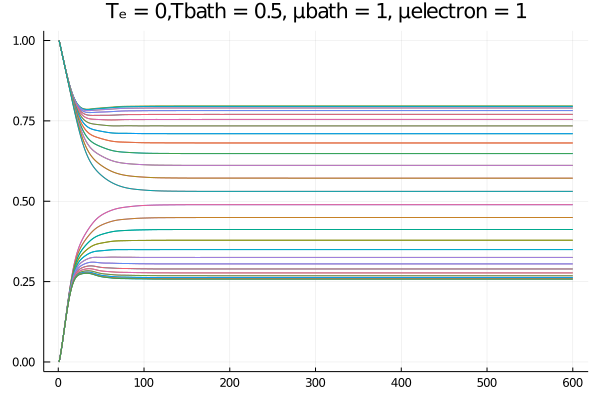

In [135]:
b2=[]
boxinitindex
testrange
list=[1 10]
for m=1:length(V_ph)
    b = Array{ComplexF64}(undef,testrange)
    for i=1:testrange
        #b[i] = Gᴿmatrix[m][i,1]
        b[i] = (imag(Gᴷmatrix[m][i,i])+1)*0.5
        #b[i] = Gᴷmatrix[m][i,i]
    end
    push!(b2,b)
end

b2
ser = collect(1:testrange)
p=plot(ser,real.(b2),legend=false,title = "Tₑ = $(Tₑ),Tbath = $(Temp_bath), μbath = $(μbath), μelectron = $(μ)",lw=1) 
## label="Tbath = $(Temp_bath)"
#scatter(ser,real.(b2[9]),legend=false)
#scatter(ser,real.(b2[3]),title="highest level",legend=false)


#  (non)- Computation of renormalized energies

#### I'm using this transformation:

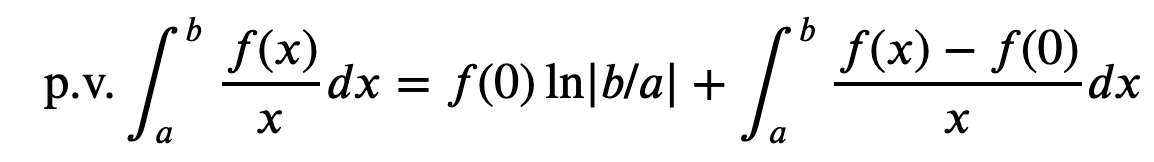


https://github.com/JuliaMath/QuadGK.jl/pull/44

In [72]:
function quadgk_cauchy(f, a, c, b)
  fc = f(c)
  g(x) = (f(x) - fc) / (x - c)
  return quadgk(g, a, c, b)[1] + fc * log(abs((b - c)/(a - c)))
end
test(a) =-(λ^2)*J(a)*(1/(2*π))

function reΣ(x)
    if -2*tB<x<2*tB
        return quadgk_cauchy(test, -2*tB, x, 2*tB)

    else
        test2(a,x ) = -(λ^2)*J(a)*(1/(2*π))*(1/(a-x))
        return quadgk(t->test2(t,x), -2*tB,2*tB)[1]
    end
end


reΣ (generic function with 1 method)

In [89]:
guru7(x) =x- reΣ(x)

guru7 (generic function with 1 method)

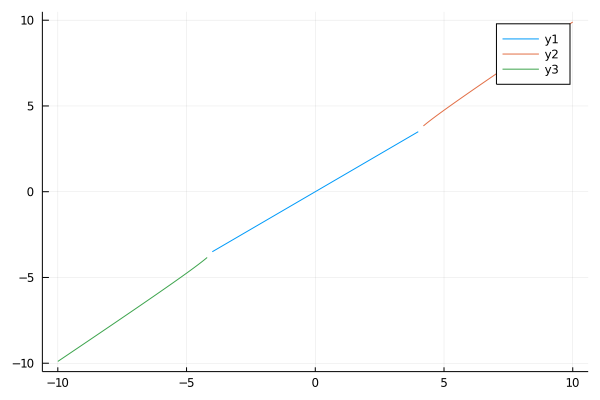

In [91]:
omval=collect(-2*tB:1e-2:2*tB)
omval2=collect(2.1*tB:1e-2:5*tB)
omval3=collect(-5*tB:1e-2:-2.1*tB)
plot(omval,guru7.(omval))
plot!(omval2,guru7.(omval2))
plot!(omval3,guru7.(omval3))

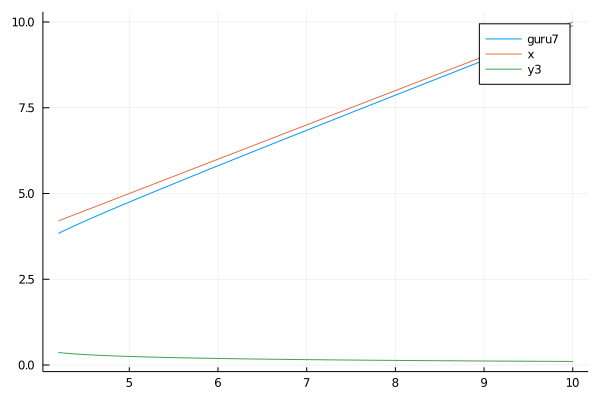

In [104]:
plot(omval2,guru7.(omval2),label="guru7")
plot!(omval2,omval2,label="x")
plot!(omval2,reΣ.(omval2))

In [79]:
savefig("rootfinder")

In [117]:
#  for i=-2*tB:4*tB/(10):2*tB
#      reΣ(i)
#  end

In [118]:
# RenomEn=[]
# for i=1:length(V_ph)
#     f1(ω) = ω-ϵₑ(i)-reΣ(ω)
#     result = find_zero(f1,ϵₑ(i))
#     push!(RenomEn,result)
# end


### Wrong: See the note below

# Comparison with thermal distribution

In [119]:
# #scatter!([75.],[fermi(ϵₑ(2),Temp_bath,μbath)])

# for k=1:length(V_ph)
#    scatter!([testrange],[fermi(RenomEn[k],Temp_bath,μbath)],xlabel="Time in units of step size", ylabel="n_k(t)",
#         title="Tₑ = $(Tₑ),Tbath = $(Temp_bath), μbath = $(μbath), μelectron = $(μ), Step size = $(h), 
#         Total time = $(h)*$(testrange)",titlefontsize=10)
# end
# current()

### Wrong: The spectral function doesn't have spikes and hence there's no sense of taking about "renormalized energies".

In [136]:
energyrange=[]
for k=1:length(V_ph)
    push!(energyrange,ϵₑ(k))
end

occupations= Array{ComplexF64,2}(undef,length(V_ph),testrange)
for i=1:testrange
    for j=1:length(V_ph)
        occupations[j,i]= (imag(Gᴷmatrix[j][i,i])+1)*0.5
    end
end


In [121]:
imΣ(x) = -1*(λ^2)*J(x)*(1/2)

quadtest(x,en) = (-1/π)*fermi(x,Temp_bath,μbath)*imΣ(x)*(1/((x-en-reΣ(x))^2+imΣ(x)^2 ) )

function newres(e)
    return quadgk(t->quadtest(t,e),-2*tB,2*tB)
end


newoccu=[]
for k=1:length(V_ph)
   val = newres(ϵₑ(k))[1]
   push!(newoccu,val) 
end

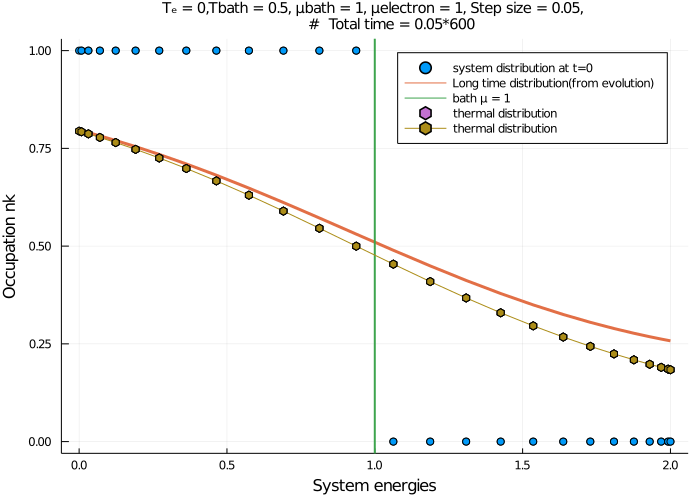

In [137]:
scatter(energyrange,real.(occupations[:,1]),label="system distribution at t=0")
#scatter!(energyrange,real.(occupations[:,5]))
#scatter!(energyrange,real.(occupations[:,10]))
#scatter!(energyrange,real.(occupations[:,20]))
plot!(energyrange,real.(occupations[:,testrange]),xlabel="System energies",ylabel="Occupation nk",title="Tₑ = $(Tₑ),Tbath = $(Temp_bath), μbath = $(μbath), μelectron = $(μ), Step size = $(h), 
       #  Total time = $(h)*$(testrange)",titlefontsize=10,label="Long time distribution(from evolution)",lw=3)

#vline!([μ],label="system μ =$(μ)",lw=2)
vline!([μbath],label="bath μ = $(μbath)",lw=2)


scatter!(energyrange,newoccu,markershape=:hexagon,label="thermal distribution",size=(700,500))
plot!(energyrange,newoccu,markershape=:hexagon,label="thermal distribution",size=(700,500))

In [132]:
#savefig("zeropntthreezeropntfive.png")

## Dispersion 

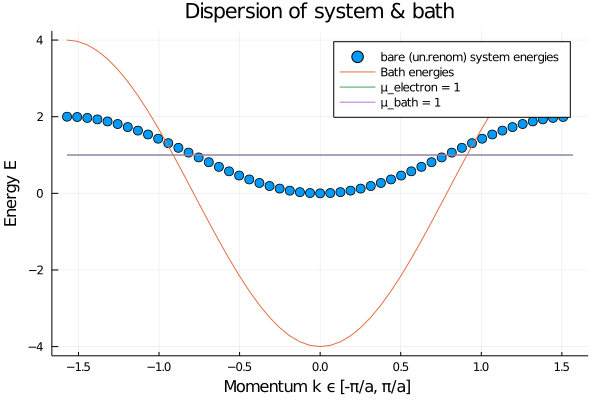

In [49]:
# disp_electron= []
# for m=1:length(V_ph)
#     push!(disp_electron,ϵₑ(m))
# end
# disp_electron

# x=collect(-π/a1:a2:π/a1)
# a
# scatter(x,disp_electron,label="bare (un.renom) system energies",markersize = 5,ylabel="Energy E")
# plot!(x, 2*-tB*cos.(x.*a1),title = "Dispersion of system & bath",label="Bath energies",xlabel="Momentum k ϵ [-π/a, π/a] ")
# plot!(collect(-π/a1:1e-2:π/a1),μ.+collect(-π/a1:1e-2:π/a1).*0,label = "μ_electron = $(μ)")
# plot!(collect(-π/a1:1e-2:π/a1),μbath.+collect(-π/a1:1e-2:π/a1).*0,label = "μ_bath = $(μbath)")

In [125]:
savefig("newdispersion")

Bath Badwidth, (s)=2.0x2

System Bath Coupling=1.0

Initial Energy Level=0.5

Initial Chem pot= -1 for blue, green, 1 for orange and yellow

Initial Temp=0.0

Bath Chem Pot= various as indicated

Bath Temp=various as indicated (0.0, 0.5, 1.0, 1.5)

Bath Spectral Function J(w)=2/s (sqrt(1-(w/2s)^2));


How Do i Understand what's the dependence of $\mu_{bath}$, $\mu_{system}$ and their respective temperature on thermalisation?

I hope you are comparing with thermal n_k = \int_{-2t_B} ^{2t_B} d \omega [ (-1/\pi) Im [ 1/[\omega- \epsilon_k -\Sigma^R(\omega) ]  ]]  [ 1/(exp((\omega -\mu)/T)+1)]

$n_k = \int_{-2t_B} ^{2t_B} d \omega [ (-1/\pi) Im [ 1/[\omega- \epsilon_k -\Sigma^R(\omega) ]  ]]  [ 1/(exp((\omega -\mu)/T)+1)]$

### The end

Here I'm checking the behaviour of the equation $\omega-\epsilon(k)-\Sigma(\omega)$

<span class="burk">Hypothesis test: Does doing the integral really give a different answer?</span>

In [126]:
# imΣ(x) = -1*(λ^2)*J(x)*(1/2)

In [9]:
roottest(x,en) = x-en-reΣ(x)

roottest (generic function with 1 method)

In [20]:
en=0.5
t=collect(3*tB:1e-1:5*tB)
plot(t,reΣ.(t))

LoadError: [91mDomainError with -1.25:[39m
[91msqrt will only return a complex result if called with a complex argument. Try sqrt(Complex(x)).[39m

In [129]:
# newres(ϵₑ(2))

In [130]:
# quadtest2(x) =(-1/π)*fermi(x,Temp_bath,μbath)*imΣ(x)*(1/((x-ϵₑ(2)-reΣ(x))^2+imΣ(x)^2 ) )
# quadgk(quadtest2,-2*tB,2*tB)

### Things I learned while coding and from discussions
- Adding a bath to your system can make the idea of "quasi-particle" itself shady if the spectral function isn't a spkiey one.
- When the spectral function has a spread, then you must never interpret excitations as "new particles with renormlaized energies": same as pnt1, there's no strict sense of what a quasiparticle is
- If in doubt, plot $Im(G^R(k,\omega)$ out - it'll act like dos

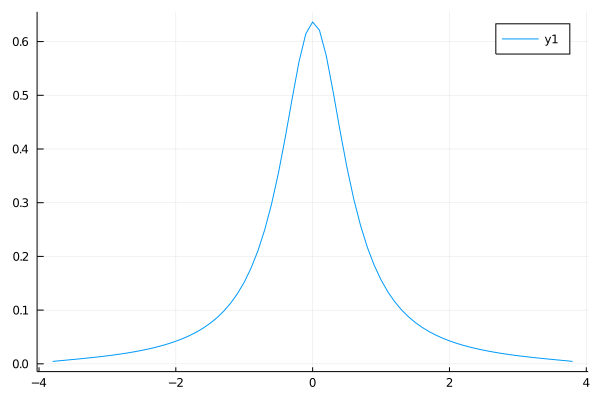

In [148]:
spectral(x)=imΣ(x)*(1/((x-ϵₑ(25)-reΣ(x))^2+imΣ(x)^2 ) )*(-1/π)
testom=collect(-1.9*tB:1e-1:1.9*tB)
plot(testom, spectral.(testom))

In [153]:
codespect=[]

function sp(ω,k)
    sum=0
    for i=1:N𝑡
        sum = sum + Gᴿmatrix[k][i,1]*exp(im*ω*(i-1)*h)*h
    end
    return imag(sum)*(-1/π)
end


sp (generic function with 1 method)

In [13]:
omval=collect(2.1*tB:1e-1:5*tB)
plot(omval,sp.(omval,25))

LoadError: [91mUndefVarError: sp not defined[39m

In [156]:
#savefig("test1")
-(λ^2)*J(a)*(1/(2*π))

In [44]:
guru(x,y) = -λ^2*(J(x)/(x-y))*(1/(2*π))

guru (generic function with 2 methods)

In [58]:
guru2(z) = quadgk(t->guru(t,z),-2*tB,2*tB)[1]

guru2 (generic function with 1 method)

In [46]:
guru3(z) = z-guru2(z)

guru3 (generic function with 2 methods)